In [8]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
import transformers
from tensorflow import keras 

In [9]:
from tensorflow.python.keras.engine.keras_tensor import KerasTensor

In [10]:
data=pd.read_csv('lenta-ru-news.csv')
data


C:\Users\Jora\anaconda3\envs\telb\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


In [11]:
frame_data=data[:10000]

In [12]:
dtf_st=frame_data[['text','topic']]

In [13]:
dtf_st.rename(columns={'y': 'text'}, inplace=True)
dtf_st

C:\Users\Jora\anaconda3\envs\telb\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text,topic
0,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека
1,"Министерство народного просвещения, в виду про...",Библиотека
2,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека
3,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека
4,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека
...,...,...
9995,Глава МВД Дагестана приказал нарядам милиции н...,Россия
9996,Представители Кремля ведут активный диалог с г...,Россия
9997,"В Москве 20 июля открывается фестиваль ""Планет...",Россия
9998,Чисто американским получился финал Уимблдонск...,Спорт


In [14]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [15]:
lst_stopwords = nltk.corpus.stopwords.words("russian")


In [16]:
dtf_st["text_clean"] = dtf_st["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf_st.head()

C:\Users\Jora\anaconda3\envs\telb\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,topic,text_clean
0,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,бои сопоцкина друскеник закончились отступлени...
1,"Министерство народного просвещения, в виду про...",Библиотека,министерство народного просвещения виду происх...
2,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,штабскапитан п н нестеров днях увидев районе ж...
3,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,фотографкорреспондент daily mirror рассказывае...
4,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,лица приехавшие варшаву люблина передают туда ...


In [17]:
dtf_st['topic'].unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт'], dtype=object)

In [92]:
nlp = gensim.models.KeyedVectors.load_word2vec_format("model_for")

In [93]:
nlp.most_similar(["русские"], topn=3)

[('жертвам', 0.9984751343727112),
 ('животных', 0.9981412887573242),
 ('системами', 0.9980924129486084)]

In [94]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["Мир"] = get_similar_words(['санкции'], 
                  top=30, nlp=nlp)
dic_clusters["Спорт"] = get_similar_words(['допинг']
                  , top=30, nlp=nlp)
dic_clusters["Россия"] = get_similar_words(['война'], 
                   top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

Мир :  ['изменений', 'справку', 'экономических', 'проголосуют', 'требованием'] ... 31
Спорт :  ['филиалы', 'клюйверт', 'забросил', 'коммерческую', 'бело'] ... 31
Россия :  ['неоднократно', 'особого', 'фронтом', 'действиями', 'проявил'] ... 31


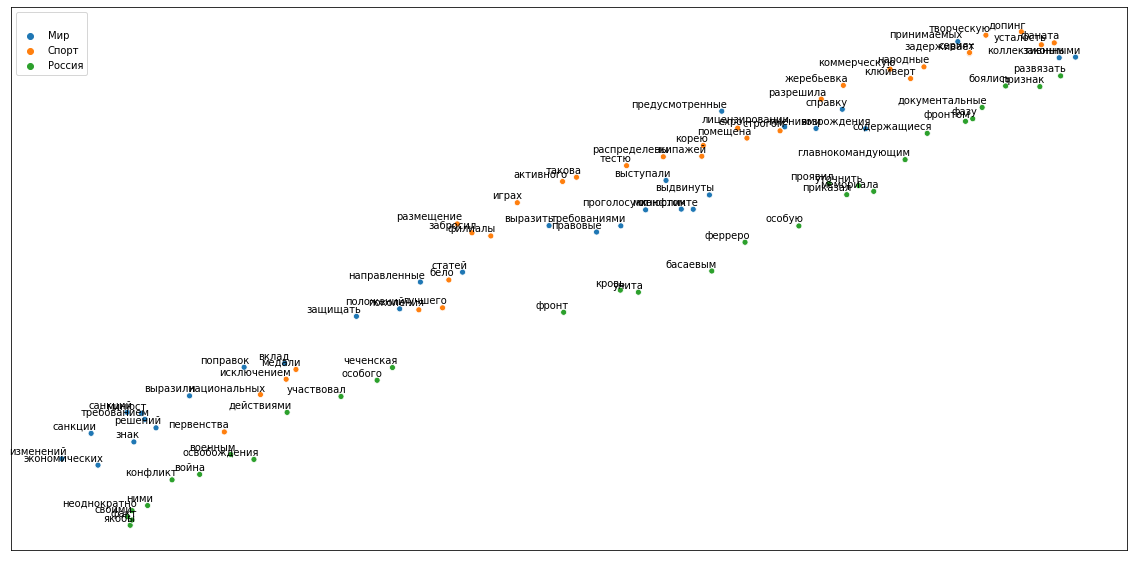

In [95]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)

ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

In [96]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)
nlp_trans = transformers.TFBertModel.from_pretrained('bert-base-multilingual-uncased')
lst_vocabulary = list(tokenizer.vocab.keys())

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [97]:
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp_trans(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
## create list of news vector


In [98]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp_trans).mean(0) for k,v
         in dic_clusters.items()}

In [99]:
text='война'

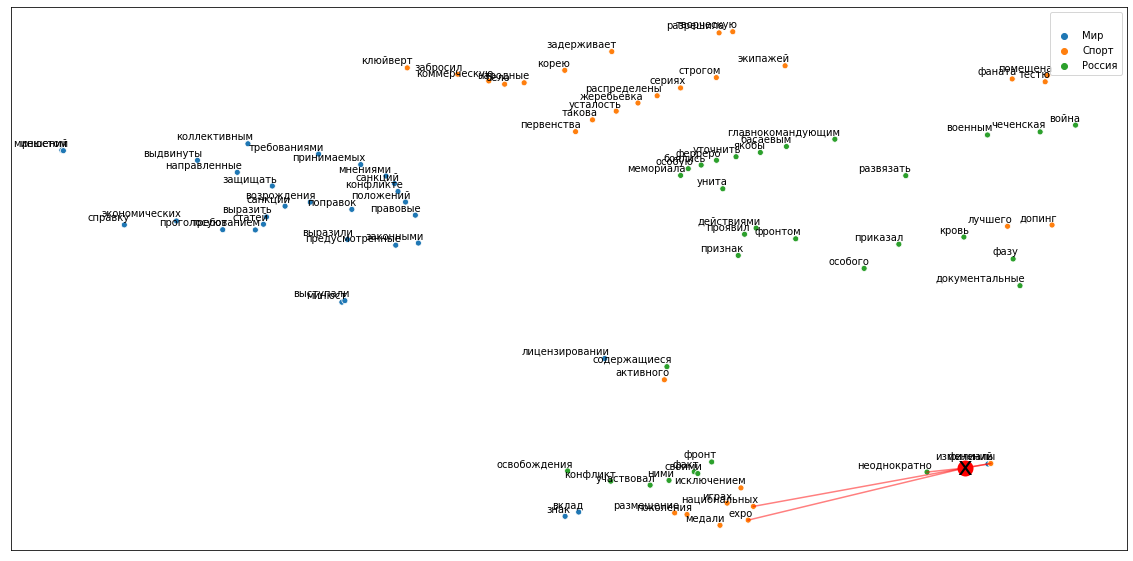

In [100]:
## create embedding Matrix
y = np.concatenate([utils_bert_embedding(v, tokenizer, nlp_trans) for v in 
                    dic_clusters.values()])
X = utils_bert_embedding(text, tokenizer,
                   nlp_trans).mean(0).reshape(1,-1)
M = np.concatenate([y,X])

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
M = pca.fit_transform(M)
y, X = M[:len(y)], M[len(y):]

## create dtf clusters
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(y[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)

## plot clusters
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[],yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

## add txt_instance
ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
ax.annotate("x", xy=(X[0][0],X[0][1]),ha='center', va='center', fontsize=25)

## calculate similarity
sim_matrix = metrics.pairwise.cosine_similarity(X, y)

## add top similarity
for row in range(sim_matrix.shape[0]):
    ### sorted {keyword:score}
    dic_sim = {n:sim_matrix[row][n] for n in 
               range(sim_matrix.shape[1])}
    dic_sim = {k:v for k,v in sorted(dic_sim.items(), 
                key=lambda item:item[1], reverse=True)}
    ### plot lines
    for k in dict(list(dic_sim.items())[0:5]).keys():
        p1 = [X[row][0], X[row][1]]
        p2 = [y[k][0], y[k][1]]
        ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
plt.show()

In [74]:
# def explainer_similarity_classif(tokenizer, nlp, dic_clusters, txt_instance, token_level=False, top=5, figsize=(20,10)):
#     ## create embedding Matrix
#     y = np.concatenate([utils_bert_embedding(v, tokenizer, nlp) for v in dic_clusters.values()])
#     X = utils_bert_embedding(txt_instance, tokenizer, nlp) if token_level is True else utils_bert_embedding(txt_instance, tokenizer, nlp).mean(0).reshape(1,-1)
#     M = np.concatenate([y,X])
    
#     ## pca
#     pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
#     M = pca.fit_transform(M)
#     y, X = M[:len(y)], M[len(y):]
    
#     ## create dtf clusters
#     dtf = pd.DataFrame()
#     for k,v in dic_clusters.items():
#         size = len(dtf) + len(v)
#         dtf_group = pd.DataFrame(y[len(dtf):size], columns=["x","y"], index=v)
#         dtf_group["cluster"] = k
#         dtf = dtf.append(dtf_group)
        
#     ## plot clusters
#     fig, ax = plt.subplots(figsize=figsize)
#     sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
#     ax.legend().texts[0].set_text(None)
#     ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
#     for i in range(len(dtf)):
#         ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    
#     ## add txt_instance
#     if token_level is True:
#         tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(txt_instance))[1:-1]
#         dtf = pd.DataFrame(X, columns=["x","y"], index=tokens)
#         dtf = dtf[~dtf.index.str.contains("#")]
#         dtf = dtf[dtf.index.str.len() > 1]
#         X = dtf.values
#         ax.scatter(x=dtf["x"], y=dtf["y"], c="red")
#         for i in range(len(dtf)):
#             ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
#     else:
#         ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
#         ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)
    
#     ## calculate similarity
#     sim_matrix = utils_cosine_sim(X,y) 

#     ## add top similarity
#     for row in range(sim_matrix.shape[0]):
#         ### sorted {keyword:score}
#         dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
#         dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
#         ### plot lines
#         for k in dict(list(dic_sim.items())[0:top]).keys():
#             p1 = [X[row][0], X[row][1]]
#             p2 = [y[k][0], y[k][1]]
#             ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
#     plt.show()

In [81]:
# def utils_cosine_sim(a, b, nlp=None):
#     ## string vs string = score
#     if (type(a) is str) or (type(b) is str):
#         nlp = gensim.models.KeyedVectors.load_word2vec_format("model_for")
#         cosine_sim = nlp.similarity(a,b)
        
#     else:
#         ## vector vs vector = score
#         if (len(a.shape) == 1) and (len(a.shape) == 1):
#             a = a.reshape(1,-1)
#             b = b.reshape(1,-1)
#             cosine_sim = metrics.pairwise.cosine_similarity(a, b)[0][0]  #np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
        
#         ## matrix vs matrix = matrix (rows_a x rows_b)
#         else:
#             a = a.reshape(1,-1) if len(a.shape) == 1 else a
#             b = b.reshape(1,-1) if len(b.shape) == 1 else b
#             cosine_sim = metrics.pairwise.cosine_similarity(a, b)
#     return cosine_sim

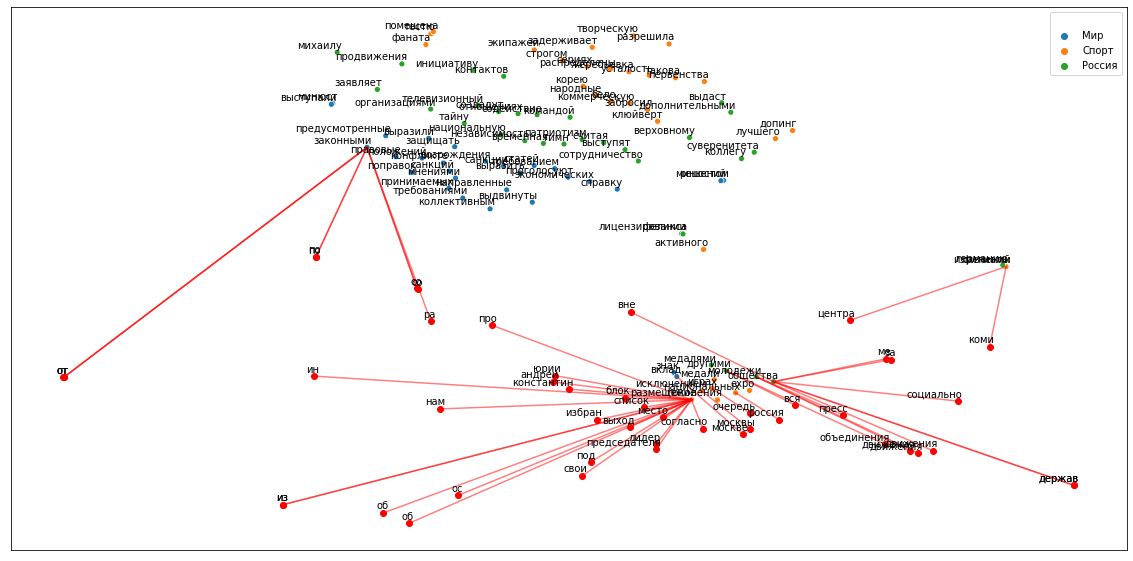

In [84]:
# explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf_st["text_clean"].iloc[i], 
#                              token_level=True, top=1, figsize=(20,10))